# Stage 2: Text classification

In [1]:
import pandas as pd
import numpy as np
import regex,os
import requests
import unidecode
import os, glob 
import cv2
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil, sys
import urllib.request
from wordcloud import WordCloud
from pathlib import Path  

In [2]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

In [3]:
# Constants 
MODELS = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=1, C=100.0,solver='lbfgs'),
]

In [4]:
cwd = os.getcwd()
filepath = Path(cwd+'/dataset_class.csv')  
df_cat = pd.read_csv(filepath)

In [7]:
X  = df_cat['nombre_preproc']
Y  = df_cat['numeric_category']

### BOW

In [10]:
cv_bow = CountVectorizer()
X_bow = cv_bow.fit_transform(X) 
X_features = X_bow.toarray()
Y_labels = Y
X_train, X_test, y_train, y_test = train_test_split(X_features, Y_labels, stratify=Y_labels, random_state=42)

In [11]:
X_features.shape

(31923, 22181)

### Cross Validation

In [12]:
models_bow = MODELS

In [13]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models_bow)))

In [14]:
entries = []
for model in tqdm(models_bow):
    model_name = model.__class__.__name__h
    print(model_name)
    accuracies = cross_val_score(model, X_features, Y_labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

  0%|                                                                                                                                                                               | 0/3 [00:00<?, ?it/s]

LinearSVC


 33%|███████████████████████████████████████████████████████▎                                                                                                              | 1/3 [03:57<07:55, 237.96s/it]

MultinomialNB


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2/3 [1:03:02<36:22, 2182.79s/it]

LogisticRegression


/Users/adelaidazuluaga/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adelaidazuluaga/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

In [15]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc.sort_values(by='Mean Accuracy',ascending=False)

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.823262,0.006334
MultinomialNB,0.819252,0.015871
LogisticRegression,0.812486,0.006126


# TF-IDF

In [22]:
X  = df_cat['nombre_preproc']
Y  = df_cat['numeric_category']

In [23]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features_tfidf = tfidf.fit_transform(X).toarray()
labels = Y

In [24]:
features_tfidf.shape

(31923, 12160)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features_tfidf, labels, 
                                                    test_size=0.25,
                                                    random_state = 0, stratify=labels)

In [26]:
models = MODELS
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [28]:
entries = []
for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_tfidf, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2/3 [01:30<00:43, 43.68s/it]/Users/adelaidazuluaga/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adelaidazuluaga/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (

In [29]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.830623,0.008775
LogisticRegression,0.812141,0.006611
MultinomialNB,0.820755,0.018946


CONCLUSIÓN: EL DESEMPEÑO CON TF-IDF ES SUPERIOR... SE OBTIENE EL RESULTADO CON TF-IDF y SVC

## TF-IDF + Linear SVC

In [75]:
cwd = os.getcwd()
filepath = Path(cwd+'/dataset_class.csv')  
df_cat = pd.read_csv(filepath)
X  = df_cat['nombre_preproc']
Y  = df_cat['numeric_category']

In [76]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features_tfidf = tfidf.fit_transform(X).toarray()
labels = Y
X_train, X_test, y_train, y_test = train_test_split(features_tfidf, labels, 
                                                    test_size=0.25,
                                                    random_state = 0, stratify=labels)

In [77]:
classifier = LinearSVC(random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
# Classification metrics

out_report = classification_report(y_test, y_pred)

print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', out_report)


 Accuracy:  0.8275905275028193

Classification Report

               precision    recall  f1-score   support

           0       0.86      0.89      0.88       246
           1       0.85      0.91      0.88       250
           2       0.90      0.93      0.91       250
           3       0.97      0.97      0.97       250
           4       0.88      0.88      0.88       250
           5       0.79      0.82      0.81       250
           6       0.97      0.98      0.97       250
           7       0.87      0.86      0.86       250
           8       0.83      0.80      0.81       249
           9       0.94      0.90      0.92       249
          10       0.94      0.91      0.93       250
          11       0.90      0.87      0.89       249
          12       0.75      0.78      0.76       250
          13       0.89      0.93      0.91       250
          14       0.39      0.36      0.38       250
          15       0.81      0.84      0.83       249
          16       0.79 

In [78]:
categ_dict = dict(zip(df_cat['numeric_category'], df_cat['categoria']))

In [79]:
y_pred_numbs = sorted(pd.unique(y_test)) #xticks and y_ticks 
x_tick_labels = [categ_dict[elem] for elem in y_pred_numbs]

/var/folders/_2/mn5plcvd0135m5y5pgyz6zpm0000gn/T/ipykernel_24803/1708141866.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom_matr = np.expand_dims(C.astype(np.float).sum(axis=1),0).transpose()


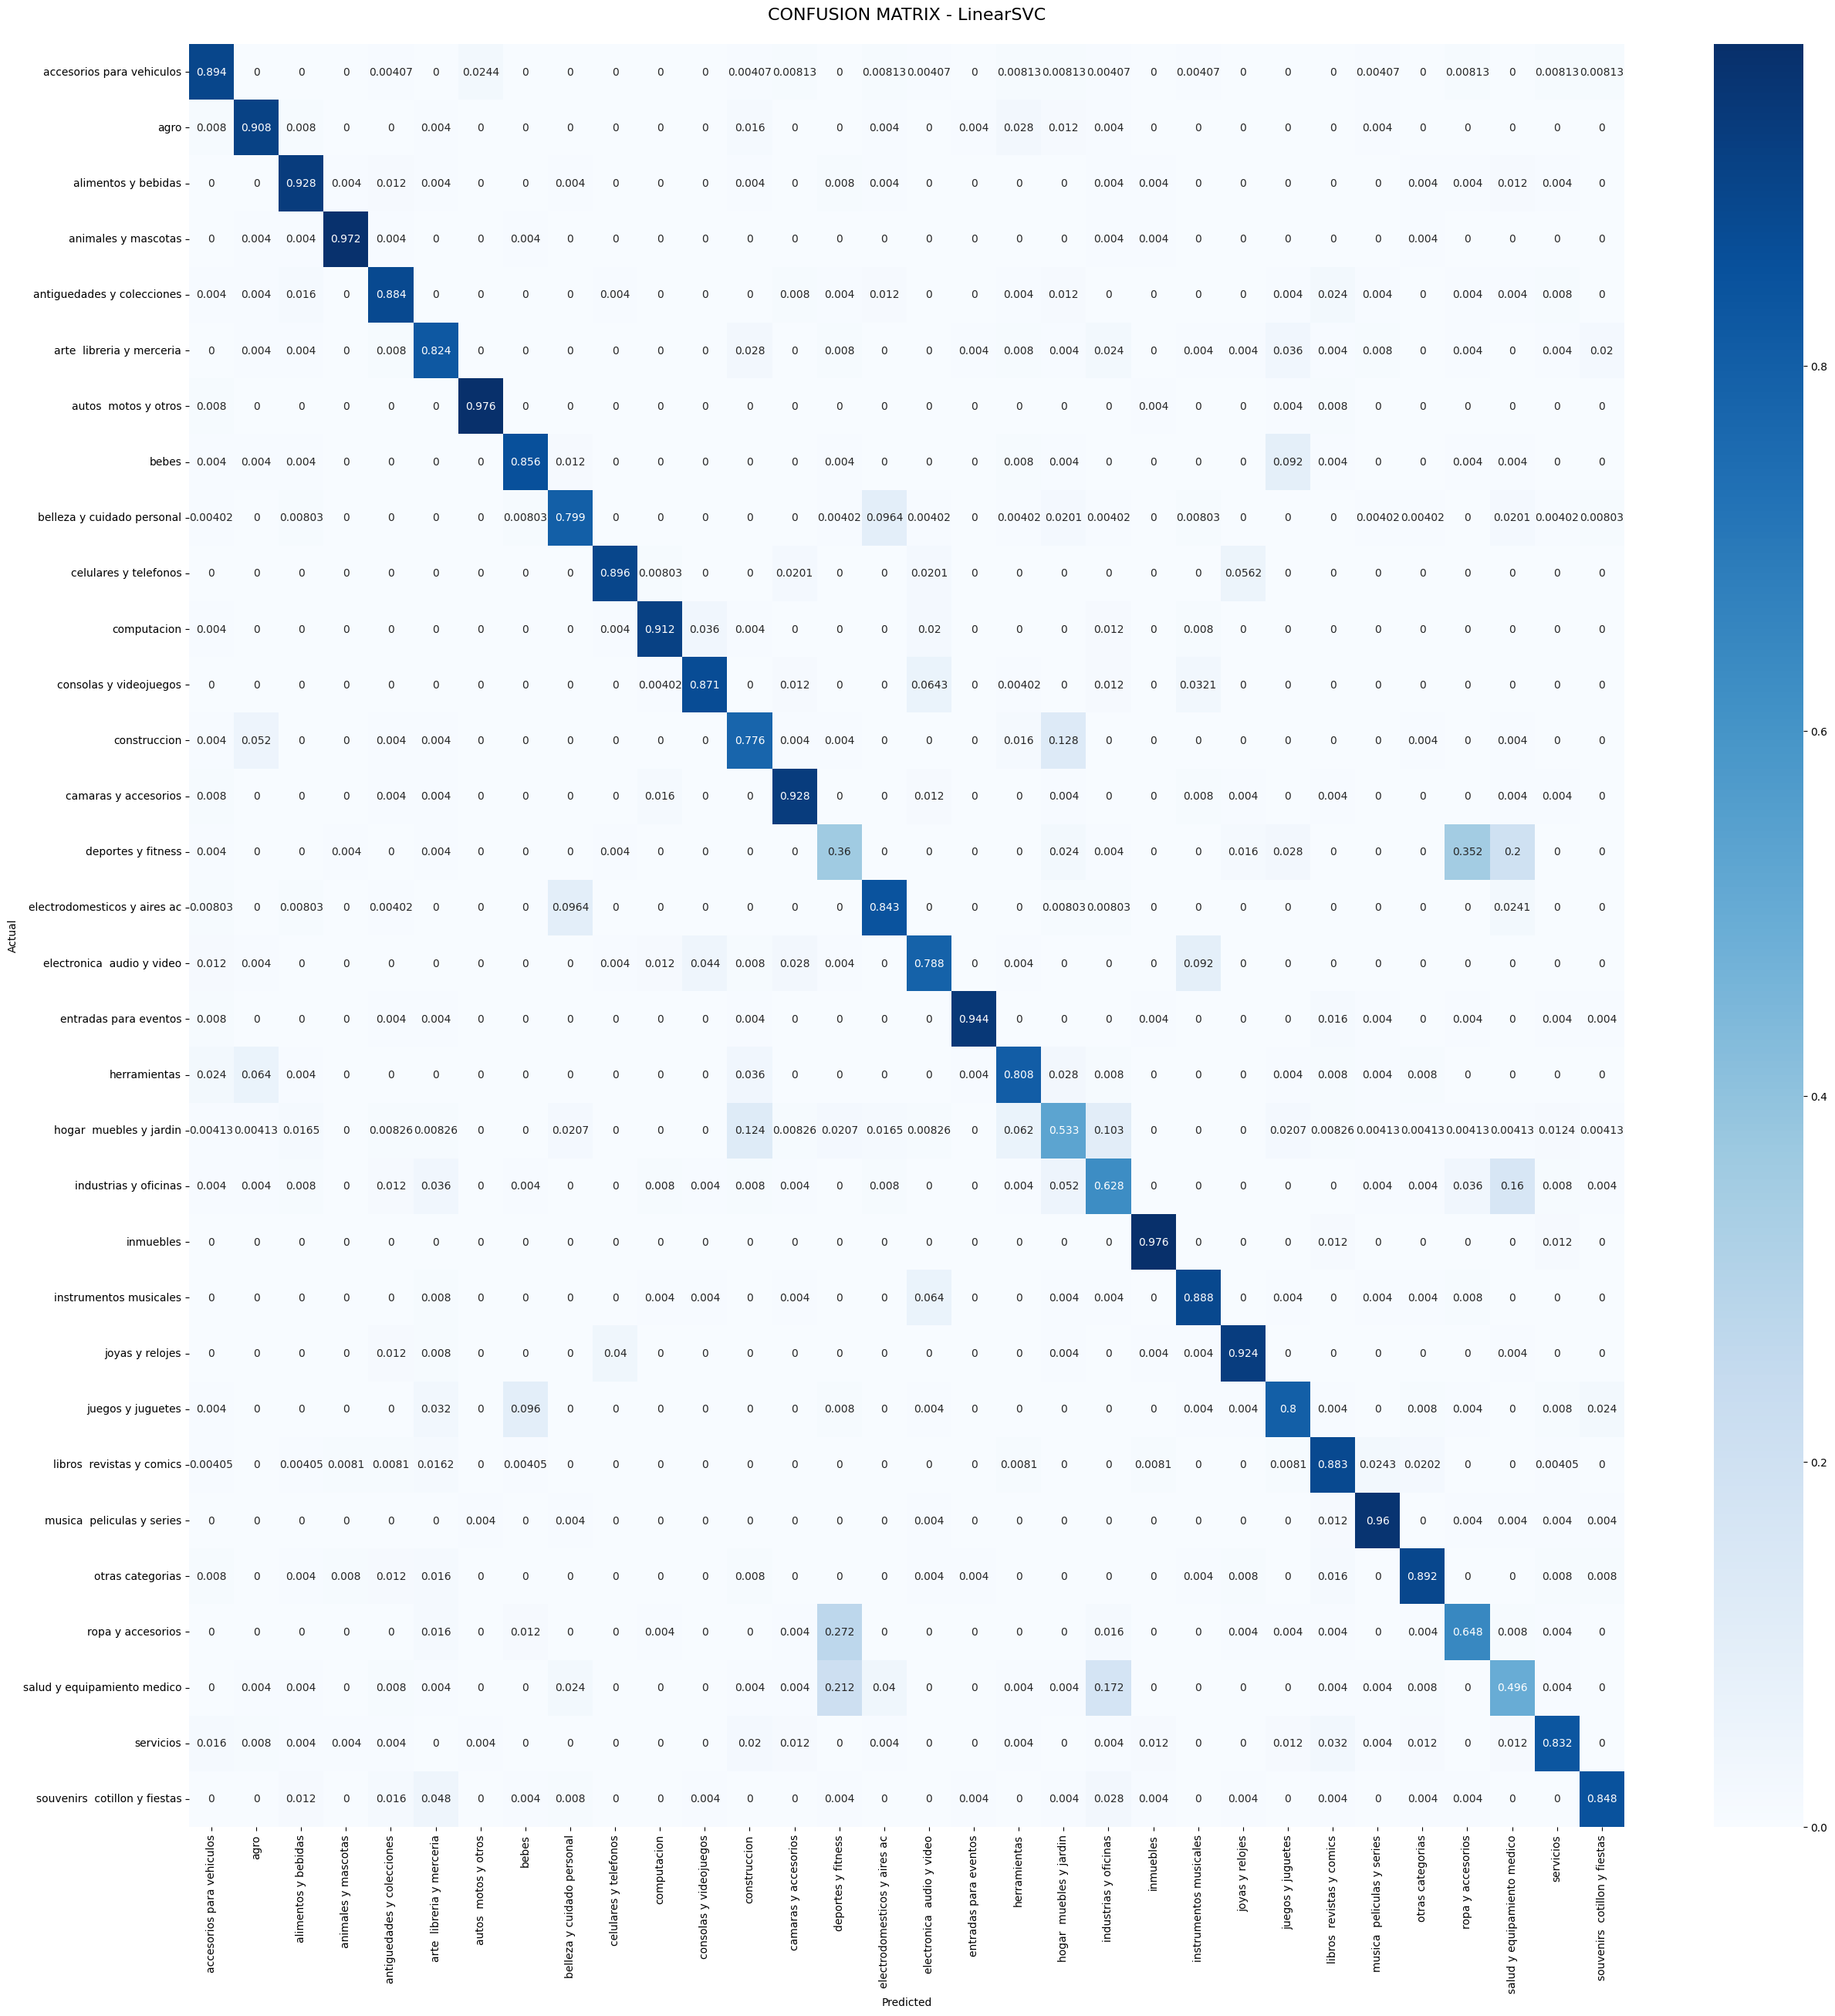

In [80]:
from scipy.stats import randint
import seaborn as sns 
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(y_test, y_pred)
C= confusion_matrix(y_test, y_pred)
denom_matr = np.expand_dims(C.astype(np.float).sum(axis=1),0).transpose()
conf_mat = C / denom_matr
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='.3g',
            xticklabels=x_tick_labels, yticklabels=x_tick_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

## Sub categorías

In [35]:
cwd = os.getcwd()
filepath = Path(cwd+'/dataset_sub_cats.csv')  
df_subcat = pd.read_csv(filepath)
X  = df_subcat['nombre_preproc']
Y  = df_subcat['numeric_sub_cat']

In [39]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features_tfidf = tfidf.fit_transform(X).toarray()
labels = Y
X_train, X_test, y_train, y_test = train_test_split(features_tfidf, labels, 
                                                    test_size=0.25,
                                                    random_state = 0, stratify=labels)

In [40]:
classifier = LinearSVC(random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
# Classification metrics

out_report = classification_report(y_test, y_pred)

print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', out_report)


 Accuracy:  0.7298194646192157

Classification Report

               precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.67      0.67      0.67        12
           2       0.80      0.92      0.86        13
           3       0.75      0.46      0.57        13
           4       0.93      1.00      0.96        13
           5       0.90      0.75      0.82        12
           6       0.37      0.58      0.45        12
           7       0.89      0.67      0.76        12
           8       0.70      0.58      0.64        12
           9       0.80      0.67      0.73        12
          10       0.44      0.31      0.36        13
          11       0.62      0.62      0.62        13
          12       1.00      1.00      1.00        12
          13       0.60      0.69      0.64        13
          14       0.76      0.76      0.76        25
          15       0.76      1.00      0.87        13
          16       0.89 

/Users/adelaidazuluaga/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adelaidazuluaga/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adelaidazuluaga/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [45]:
categ_dict = dict(zip(df_subcat['numeric_sub_cat'], df_subcat['sub_categoria']))


In [46]:
y_pred_numbs = sorted(pd.unique(y_test)) #xticks and y_ticks 
x_tick_labels = [categ_dict[elem] for elem in y_pred_numbs]

# Conclusion

* Debemos usar un clasificador de texto para productos externos que probablemente no tengan una etiqueta generada.
* Asumiendo que al ingresar el producto únicamente se cuenta con imagen y nombre del producto, se genera una categoría y sub categoría para el mismo
* Con estas dos etiquetas se genera el label group, para entrar al modelo de similitud entre productos
* Para la similitud entre productos también se tendrá en cuenta el precio del producto. Se encontrará el rango de precios por categoría y subcategoría para encontrar las cotas superiores e inferiores para la toma de decisiones